In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.ndimage import label
from tensorflow.keras.models import load_model

In [3]:
def group_contours_into_rows(rects, threshold=10):
    if not rects:
        return []
    
    # Sort rectangles by y-coordinate (top edge)
    sorted_rects = sorted(rects, key=lambda r: r[1])
    
    rows = []
    current_row = [sorted_rects[0]]
    for rect in sorted_rects[1:]:
        # If the y-coordinate difference is small, add to the current row
        if rect[1] - current_row[-1][1] < threshold:
            current_row.append(rect)
        else:
            rows.append(current_row)
            current_row = [rect]
    if current_row:
        rows.append(current_row)
    
    # Sort each row by x-coordinate (left to right)
    for row in rows:
        row.sort(key=lambda r: r[0])
    
    return rows

In [4]:
# Find characters in the resulting images


def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Show binary image for debugging
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Binary License Plate')
    plt.show()

    # Find all potential character contours
    cntrs, _ = cv2.findContours(img_binary_lp.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    rects = []
    for cntr in cntrs:
        x, y, w, h = cv2.boundingRect(cntr)
        # Relaxed dimensions to capture characters from both rows
        if 5 < w < 50 and 10 < h < 60:
            rects.append((x, y, w, h))
    
    # Group contours into rows
    rows = group_contours_into_rows(rects, threshold=10)
    
    # Visualize detected characters by row
    ii = img_lp.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Colors for different rows
    for i, row in enumerate(rows):
        color = colors[i % len(colors)]
        for x, y, w, h in row:
            cv2.rectangle(ii, (x, y), (x + w, y + h), color, 2)
    plt.imshow(cv2.cvtColor(ii, cv2.COLOR_BGR2RGB))
    plt.title('Detected Characters by Row')
    plt.show()
    
    # Extract character images
    char_images = []
    for row in rows:
        row_chars = []
        for x, y, w, h in row:
            char = img_binary_lp[y:y+h, x:x+w]
            char = cv2.resize(char, (20, 40))
            char = cv2.subtract(255, char)
            char_copy = np.zeros((44, 24))
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            row_chars.append(char_copy)
        char_images.extend(row_chars)
    
    return char_images


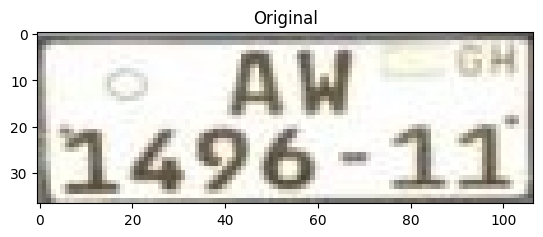

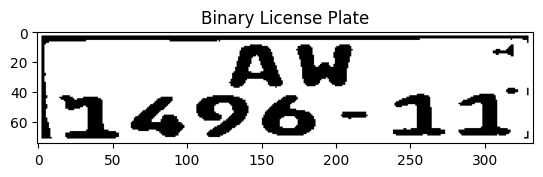

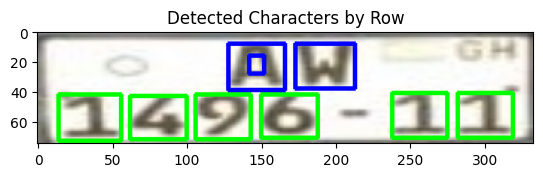

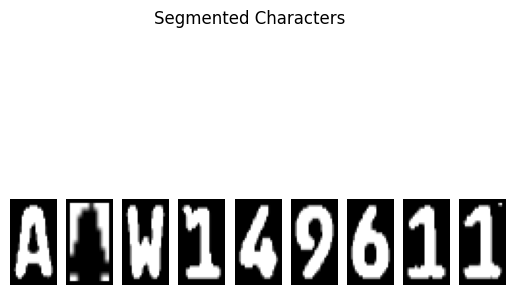

In [10]:
# Example usage
image_path = 'plate_crops/img_000029_0.jpg'  # Replace with your image path61,29
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

char_images = segment_characters(image)

# Show all segmented characters
for i, char_img in enumerate(char_images):
    plt.subplot(1, len(char_images), i + 1)
    plt.imshow(char_img, cmap='gray')
    plt.axis('off')
plt.suptitle("Segmented Characters")
plt.show()

In [6]:
# import numpy as np
# import cv2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the CNN model
# model = Sequential()
# model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (16,16), activation='relu', padding='same'))
# model.add(Conv2D(64, (8,8), activation='relu', padding='same'))
# model.add(Conv2D(64, (4,4), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(4, 4)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(36, activation='softmax'))

# # Compile the model
# model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# # Set up data generators
# train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
# path = 'data/data'
# train_generator = train_datagen.flow_from_directory(
#     path + '/train',
#     target_size=(28,28),
#     batch_size=1,
#     class_mode='sparse'
# )

# validation_generator = train_datagen.flow_from_directory(
#     path + '/val',
#     target_size=(28,28),
#     batch_size=1,
#     class_mode='sparse'
# )


In [7]:
# Train the model (uncomment and adjust epochs as needed)
model = load_model('final_model.keras')


In [8]:
# Function to convert grayscale to 3-channel image
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

# Function to predict and display results
def show_results(char_list):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char_list:
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = np.argmax(model.predict(img), axis=-1)[0]
        character = dic[y_]
        output.append(character)
    plate_number = ''.join(output)
    return plate_number

In [11]:
# Example usage (uncomment and provide your own char_list)
char_list = [char_images[i] for i in range(len(char_images))]
plate_number = show_results(char_list)
print(plate_number)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
ADW149611
